# D-Trace loss in Sparse Precision Matrix - Implementation

Based on the research Sparse precision matrix estimation via lasso penalized D-trace loss by Teng Zhang and Hui Zou

In [217]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt

In [218]:
sp500 = pd.read_csv('S&P 500 Companies.csv') #sp500 companies

tickers = sp500['Symbol'] #Ticker extraction

In [219]:
randomsp500 = tickers.sample(n = 10) #Sample x random stocks
randomsp500 = randomsp500.tolist()

start = '2024-06-21'
end = '2025-06-21'
closes = yf.download(randomsp500, start = start, end = end, auto_adjust = True)['Close'] #Get close data for above timeframe
daily_chgs = closes.pct_change().iloc[1:]
sigma_hat = np.cov(daily_chgs.T)

[                       0%                       ]

[*********************100%***********************]  10 of 10 completed


## Algorithm for estimating precision matrix

First we will use algorithm 2, then check eigenvalues to see if positive definiteness is sastisfied

First, lets define the auxilary functions

In [220]:
def G(A, B):
    sigma, U = np.linalg.eigh(A)

    sigma_matrix = sigma[:, None] + sigma[None, :]
    C = 2 / sigma_matrix

    B_tilde = U.T @ B @ U

    Theta_tilde = B_tilde * C #Hadamard product

    Theta = U @ Theta_tilde @ U.T

    return Theta


def S(A, lda):
    A_new = A.copy()

    for i in range(len(A_new)):
        for j in range(len(A_new)):
            if i != j:
                val = A[i, j]

                if val > lda:
                    A_new[i, j] = val - lda
                if val < lda:
                    A_new[i, j] = val + lda
                else:
                    A_new[i, j] = 0
    
    return A_new

In [221]:
Theta_0_curr = np.diag(1 / np.diag(sigma_hat))
Theta_0_prev = Theta_0_curr.copy()
Theta_curr = np.diag(1 / np.diag(sigma_hat))
Theta_prev = Theta_curr.copy()

Lambda_curr = np.zeros_like(sigma_hat)
Lambda_prev = Lambda_curr.copy()

rho = 1 #Set rho as hyperparamter of 1 for now
lda_n = 1 #Parameter for size of penalty for sprasity

epsilon = 1e-7

k = 0
while k < 10000:
    k += 1
    
    Theta_prev = Theta_curr.copy()

    A = sigma_hat + rho * np.eye(len(sigma_hat))
    B = np.eye(len(sigma_hat)) + rho * Theta_0_prev - Lambda_curr

    Theta_curr = G(A, B)

    Theta_0_prev = Theta_0_curr.copy()
    
    C = Theta_curr + 1 / rho * Lambda_curr
    d = 1 / rho * lda_n
    Theta_0_curr = S(C, d)

    Lambda_prev = Lambda_curr.copy()

    Lambda_curr = Lambda_prev + rho * (Theta_curr - Theta_0_curr)

    condition1 = np.linalg.norm(Theta_curr - Theta_prev, 'fro') / (max(1, np.linalg.norm(Theta_prev, 'fro'), np.linalg.norm(Theta_curr, 'fro')))
    condition2 = np.linalg.norm(Theta_0_curr - Theta_0_prev, 'fro') / (max(1, np.linalg.norm(Theta_0_prev, 'fro'), np.linalg.norm(Theta_0_curr, 'fro')))

    if condition1 < epsilon and condition2 < epsilon:
        Theta_sparse = Theta_curr
        break

Theta_sparse = Theta_curr

eigenvalues = np.linalg.eigvals(Theta_sparse)

nonPDeigs = 0
for eig in eigenvalues:
    if eig <= 0:
        nonPDeigs += 1
        print(eig, 'So this is not Positive Definite - use Algorithm 1')

if nonPDeigs != 0:
    print('Need PD restriction')
else:
    print('Precision Matrix is positive definite - good to go')

Precision Matrix is positive definite - good to go


The eigenvalues are quite large which is good, indicating this less computational algorithm outputs the same as the other one! Next, lets force small values to be 0 because they are essentially conditionally independent.

In [222]:
threshold = 1e-2
Theta_GMRF = Theta_sparse.copy()

# Zero out elements whose absolute value is less than the threshold
Theta_GMRF[np.abs(Theta_GMRF) < threshold] = 0.0

## Gaussian Markov Random Field

Now, we have a sparse precision matrix. We will try to do some analysis using ideas from GMRF

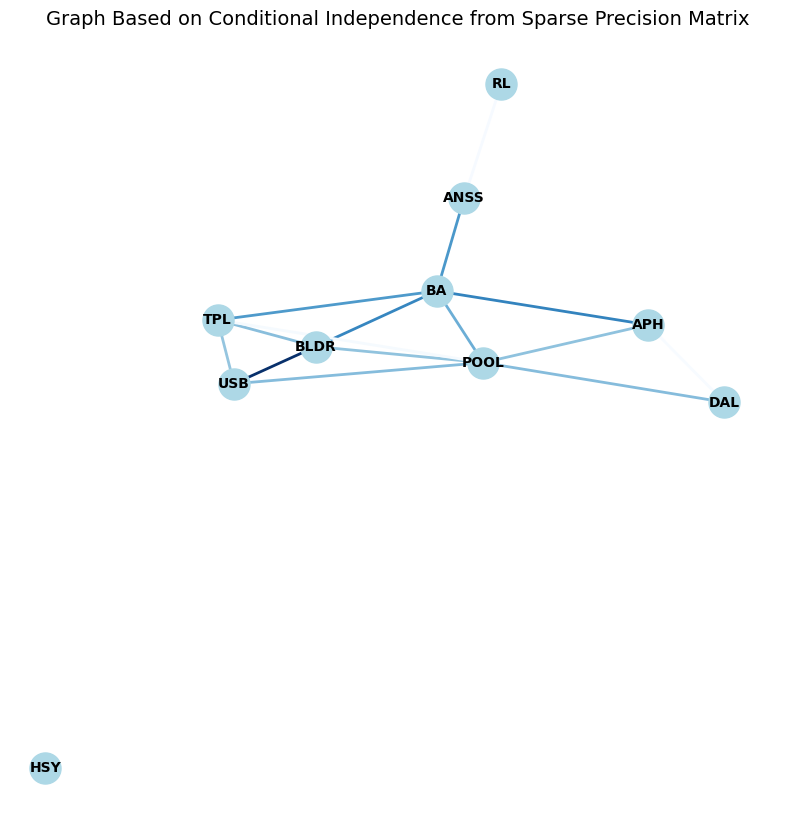

In [223]:
tickers = randomsp500 
G = nx.Graph()
G.add_nodes_from(tickers) 

n = len(tickers)
threshold = 1e-4

for i in range(n):
    for j in range(i + 1, n):
        weight = Theta_GMRF[i, j]
        if abs(weight) > threshold:
            G.add_edge(tickers[i], tickers[j], weight=weight)

pos = nx.spring_layout(G, seed=42)
edges = G.edges()
weights = [abs(G[u][v]['weight']) for u, v in edges]

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, edge_color=weights, edge_cmap=plt.cm.Blues)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
plt.title("Graph Based on Conditional Independence from Sparse Precision Matrix", fontsize=14)
plt.axis('off')
plt.show()

In [232]:
print(Theta_GMRF)
print(randomsp500)

[[3.80838286e+03 5.85790899e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.99970329e+00 1.44495514e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.85790899e-01 1.74560108e+03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.49432795e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.63034925e+03 1.47275824e+00
  0.00000000e+00 1.98054291e+00 1.43529642e+00 0.00000000e+00
  2.66328592e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.47275824e+00 1.30250492e+03
  0.00000000e+00 1.80589019e+00 6.08497076e-01 0.00000000e+00
  1.41085458e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.02769348e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.97521724e-01]
 [1.99970329e+00 0.00000000e+00 1.98054291e+00 1.80589019e+00
  0.00000000e+00 3.38779919e+03 1.61999268e+00 0.00000000e+00
  0.00000000e+00 1.82511458e+00]
 [1.44495514e+00 1.49432795e+00 1.43529642e+00 6.08497076e

In [233]:
mean_rets = daily_chgs.mean()
cov_rets = np.linalg.inv(Theta_GMRF)
print(mean_rets)

Ticker
ANSS    0.000247
APH     0.001575
BA      0.000780
BLDR   -0.000507
DAL     0.000337
HSY     0.000033
POOL   -0.000357
RL      0.001882
TPL     0.002055
USB     0.000709
dtype: float64
